# 🎬 Jellyfin Recommender System - Learning Notebook

This notebook walks through how the recommendation engine works, with explanations of:
- TF-IDF (Term Frequency - Inverse Document Frequency)
- Cosine Similarity
- User Profile Building
- Hybrid Scoring

## Setup & Imports

In [22]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Paths - use absolute path for Jupyter
PROJECT_ROOT = Path("/home/sjscarface/piprojects/recommendersystem")
DATA_DIR = PROJECT_ROOT / "data"
CANDIDATES_FILE = DATA_DIR / "candidates.json"
WATCH_HISTORY_FILE = DATA_DIR / "watch_history.json"

print(f"📁 Project root: {PROJECT_ROOT}")
print(f"📁 Data directory: {DATA_DIR}")

📁 Project root: /home/sjscarface/piprojects/recommendersystem
📁 Data directory: /home/sjscarface/piprojects/recommendersystem/data


## 1. Load the Data

In [23]:
# Load candidates from TMDB
with open(CANDIDATES_FILE, "r") as f:
    candidates_data = json.load(f)

candidates = candidates_data["candidates"]
print(f"✅ Loaded {len(candidates)} candidates")

# Convert to DataFrame for easier exploration
df = pd.DataFrame(candidates)
df.head()

✅ Loaded 710 candidates


,tmdb_id,title,type,year,genres,keywords,overview,tagline,vote_average,vote_count,...,cast,creators,original_language,poster_path,status,number_of_seasons,recommended_because,recommendation_strength,runtime,directors
0,1396,Breaking Bad,tv,2008,"[Drama, Crime]","[new mexico, drug dealer, narcissism, psychopa...","Walter White, a New Mexico chemistry teacher, ...",Change the equation.,8.935,16843,...,"[{'name': 'Bryan Cranston', 'popularity': 6.13...",[Vince Gilligan],en,/ztkUQFLlC19CCMYHW9o1zWhJRNq.jpg,Ended,5.0,"[Rick and Morty, Family Guy, Severance, Asia, ...",6,NaN,NaN
1,60625,Rick and Morty,tv,2013,"[Animation, Comedy, Sci-Fi & Fantasy, Action &...","[time travel, grandfather, alcoholism, alien, ...",Follows a sociopathic genius scientist who dra...,"Science makes sense, family doesn't.",8.683,10587,...,"[{'name': 'Chris Parnell', 'popularity': 2.753...","[Dan Harmon, Justin Roiland]",en,/WGRQ8FpjkDTzivQJ43t94bOuY0.jpg,Returning Series,8.0,"[Family Guy, Arcane, Stranger Things, Dexter's...",5,NaN,NaN
2,615,Futurama,tv,1999,"[Animation, Comedy, Sci-Fi & Fantasy]","[spacecraft, future, space travel, melancholy,...",The adventures of a late-20th-century New York...,Defying gravity and common sense.,8.368,3582,...,"[{'name': 'Billy West', 'popularity': 1.7181, ...",[Matt Groening],en,/6ZS8SOno6kTmWz4eQ8lX8EBXOMv.jpg,Returning Series,10.0,"[Rick and Morty, Dexter's Laboratory, Family G...",4,NaN,NaN
3,1433,American Dad!,tv,2005,"[Animation, Comedy]","[central intelligence agency (cia), social sat...",The series focuses on an eccentric motley crew...,"From the creator of ""Family Guy"" comes a man w...",7.000,2282,...,"[{'name': 'Seth MacFarlane', 'popularity': 3.4...","[Matt Weitzman, Seth MacFarlane, Mike Barker]",en,/aC1q422YhQR7k82GB8gW4KoD91p.jpg,Returning Series,22.0,"[Rick and Morty, Family Guy, South Park]",4,NaN,NaN
4,62741,Kamisama Kiss,tv,2012,"[Animation, Comedy, Sci-Fi & Fantasy]","[magic, friendship, supernatural, high school,...",Nanami was just a normal high school girl down...,,8.600,992,...,"[{'name': 'Yui Horie', 'popularity': 2.2087, '...",[],ja,/5E7GL8KxpFemEFl3Lv8Fu4RuSwa.jpg,Ended,2.0,"[Arcane, SPY x FAMILY, Stranger Things]",3,NaN,NaN


In [24]:
# Check what columns we have
print("📊 Available columns:")
for col in df.columns:
    print(f"   • {col}")

📊 Available columns:
   • tmdb_id
   • title
   • type
   • year
   • genres
   • keywords
   • overview
   • tagline
   • vote_average
   • vote_count
   • popularity
   • episode_run_time
   • cast
   • creators
   • original_language
   • poster_path
   • status
   • number_of_seasons
   • recommended_because
   • recommendation_strength
   • runtime
   • directors


## 2. Load Your Watch History

In [25]:
with open(WATCH_HISTORY_FILE, "r") as f:
    watch_history = json.load(f)

# Extract unique titles you've watched
watched_titles = set()
for user_id, user_data in watch_history.items():
    for entry in user_data.get("history", []):
        title = entry.get("series_name") or entry.get("name")
        if title:
            watched_titles.add(title)

print(f"📺 You've watched {len(watched_titles)} unique titles:")
for title in list(watched_titles)[:10]:
    print(f"   • {title}")

📺 You've watched 24 unique titles:
   • Asia
   • Parasite
   • Attack on Titan: THE LAST ATTACK
   • Stranger Things
   • South Park
   • Dexter's Laboratory
   • www.UIndex.org    -    Adhurs (2010) 1080p BluRay 5.1-WORLD
   • Legally Blonde
   • Tom and Jerry Cartoons Complete Collection (1940-2007) [DVDRip] M8
   • The Louvre


---
# 📚 Understanding TF-IDF

**TF-IDF** answers: "How important is this word to THIS document vs ALL documents?"

## Formula:
```
TF-IDF(word, doc) = TF(word, doc) × IDF(word)

TF = frequency of word in document / total words in document
IDF = log(total documents / documents containing word)
```

## Example:
- "the" appears everywhere → low IDF → low TF-IDF
- "xenomorph" only in Alien movies → high IDF → high TF-IDF

## 3. Build Feature Text for Each Candidate

In [26]:
def build_feature_text(item: dict) -> str:
    """
    Combine all features into a single text string.
    
    We weight features by repetition:
    - Genres: 3x (most important)
    - Keywords: 2x (distinctive features)
    - Cast/Directors: 1x
    - Overview: 1x
    """
    parts = []
    
    # Genres (weight: 3x)
    genres = item.get("genres", [])
    parts.extend(genres * 3)
    
    # Keywords (weight: 2x)
    keywords = item.get("keywords", [])
    parts.extend(keywords * 2)
    
    # Cast names
    cast = item.get("cast", [])
    cast_names = [c["name"].replace(" ", "_") for c in cast if isinstance(c, dict)]
    parts.extend(cast_names)
    
    # Directors/Creators
    directors = item.get("directors", [])
    creators = item.get("creators", [])
    parts.extend([d.replace(" ", "_") for d in directors])
    parts.extend([c.replace(" ", "_") for c in creators])
    
    # Overview
    overview = item.get("overview", "")
    if overview:
        parts.append(overview)
    
    return " ".join(parts).lower()

# Test with one candidate
sample = candidates[0]
print(f"🎬 Sample: {sample['title']}")
print(f"\n📝 Feature text (first 500 chars):")
print(build_feature_text(sample)[:500])

🎬 Sample: Breaking Bad

📝 Feature text (first 500 chars):
drama crime drama crime drama crime new mexico drug dealer narcissism psychopath terminal illness outlaw dark comedy cancer tragedy drugs criminal meth lab drug lord high school teacher dea agent new mexico drug dealer narcissism psychopath terminal illness outlaw dark comedy cancer tragedy drugs criminal meth lab drug lord high school teacher dea agent bryan_cranston aaron_paul anna_gunn rj_mitte dean_norris betsy_brandt bob_odenkirk jonathan_banks vince_gilligan walter white, a new mexico chem


## 4. Create TF-IDF Matrix

In [27]:
# Build feature text for ALL candidates
feature_texts = [build_feature_text(c) for c in candidates]

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    stop_words='english',   # Remove common words
    max_features=5000,      # Keep top 5000 features
    ngram_range=(1, 2),     # Unigrams and bigrams
    min_df=2,               # Minimum document frequency
    max_df=0.8,             # Ignore words in >80% of docs
)

# Fit and transform
tfidf_matrix = tfidf.fit_transform(feature_texts)

print(f"✅ TF-IDF Matrix Shape: {tfidf_matrix.shape}")
print(f"   → {tfidf_matrix.shape[0]} candidates")
print(f"   → {tfidf_matrix.shape[1]} features (words/phrases)")

✅ TF-IDF Matrix Shape: (710, 5000)
   → 710 candidates
   → 5000 features (words/phrases)


In [29]:
# Let's look at the vocabulary (top features)
feature_names = tfidf.get_feature_names_out()
print(f"📖 Sample vocabulary (first 30 features):")
print(list(feature_names[:30]))

📖 Sample vocabulary (first 30 features):
['000', '10', '10th', '13', '13 year', '14', '14 year', '15', '16', '17', '17th', '17th century', '19', '1910s', '1940s', '1950s', '1956', '1960', '1960s', '1970', '1970s', '1978', '1980s', '1983', '1990', '1990s', '1996', '1999', '19th', '19th century']


## 5. Examine TF-IDF Weights for a Movie

In [30]:
# Let's see the most important features for Breaking Bad
breaking_bad_idx = 0  # It's the first candidate
bb_vector = tfidf_matrix[breaking_bad_idx].toarray().flatten()

# Get top 15 features
top_indices = bb_vector.argsort()[-15:][::-1]
print(f"🔝 Top TF-IDF features for '{candidates[breaking_bad_idx]['title']}':")
print()
for idx in top_indices:
    print(f"   {feature_names[idx]:25} → {bb_vector[idx]:.4f}")

🔝 Top TF-IDF features for 'Breaking Bad':

   drug                      → 0.2781
   new mexico                → 0.2445
   cancer                    → 0.2370
   teacher                   → 0.2307
   drugs                     → 0.2252
   mexico                    → 0.2204
   lab                       → 0.1770
   drug lord                 → 0.1770
   drugs criminal            → 0.1770
   drama crime               → 0.1768
   dea                       → 0.1691
   crime                     → 0.1649
   lord                      → 0.1630
   drug dealer               → 0.1630
   terminal illness          → 0.1580


---
# 📚 Understanding Cosine Similarity

**Cosine similarity** measures the angle between two vectors, not the distance.

```
              A · B              (dot product)
cos(θ) = ───────────── = ────────────────────────
         ||A|| × ||B||    (product of magnitudes)
```

- **1.0** = identical direction (very similar)
- **0.0** = perpendicular (unrelated)
- **-1.0** = opposite (very different)

## 6. Build User Profile

In [9]:
# Find which candidates match your watched items
watched_indices = []
matched = []

for title in watched_titles:
    for i, c in enumerate(candidates):
        if title.lower() in c.get("title", "").lower():
            watched_indices.append(i)
            matched.append(c["title"])
            break

print(f"📺 Found {len(watched_indices)} of your watched items in candidate pool:")
for m in matched:
    print(f"   • {m}")

📺 Found 8 of your watched items in candidate pool:
   • Parasite
   • Stranger Things
   • South Park
   • Legally Blonde 2: Red, White & Blonde
   • Rick and Morty
   • Kantara
   • Arcane
   • Family Guy


In [10]:
# Build user profile: AVERAGE of watched items' TF-IDF vectors
if watched_indices:
    watched_vectors = tfidf_matrix[watched_indices]
    user_profile = np.asarray(watched_vectors.mean(axis=0)).flatten()
else:
    # Fallback: use top 10 most popular
    user_profile = np.asarray(tfidf_matrix[:10].mean(axis=0)).flatten()

print(f"✅ User profile: {len(user_profile)} dimensions")

# What are YOUR top features?
top_user_indices = user_profile.argsort()[-15:][::-1]
print(f"\n👤 YOUR top preference features:")
for idx in top_user_indices:
    print(f"   {feature_names[idx]:25} → {user_profile[idx]:.4f}")

✅ User profile: 5000 dimensions

👤 YOUR top preference features:
   animation                 → 0.0951
   adult                     → 0.0841
   satire                    → 0.0642
   family                    → 0.0612
   comedy                    → 0.0604
   adult animation           → 0.0604
   dog                       → 0.0570
   animation comedy          → 0.0563
   action                    → 0.0545
   thriller                  → 0.0518
   dysfunctional             → 0.0492
   action adventure          → 0.0465
   humor social              → 0.0456
   scientist                 → 0.0446
   family adult              → 0.0436


## 7. Calculate Similarity Scores

In [13]:
# Calculate cosine similarity between YOUR profile and ALL candidates
similarities = cosine_similarity(
    user_profile.reshape(1, -1),
    tfidf_matrix
).flatten()

print(f"✅ Calculated similarity for {len(similarities)} candidates")
print(f"   Max similarity: {similarities.max():.4f}")
print(f"   Min similarity: {similarities.min():.4f}")
print(f"   Mean similarity: {similarities.mean():.4f}")

✅ Calculated similarity for 710 candidates
   Max similarity: 0.5395
   Min similarity: 0.0000
   Mean similarity: 0.0888


## 8. Hybrid Scoring

We combine multiple signals:

| Signal | Weight | Source |
|--------|--------|--------|
| Content Similarity | 40% | TF-IDF cosine similarity |
| Collaborative | 30% | TMDB recommendation_strength |
| Quality | 20% | vote_average |
| Confidence | 10% | vote_count |

In [14]:
# Calculate hybrid scores
max_strength = max(c.get("recommendation_strength", 1) for c in candidates)

results = []
for i, c in enumerate(candidates):
    content_score = similarities[i]
    collab_score = c.get("recommendation_strength", 1) / max_strength
    quality_score = c.get("vote_average", 5) / 10
    confidence = min(c.get("vote_count", 0) / 1000, 1.0)
    
    hybrid = (
        0.40 * content_score +
        0.30 * collab_score +
        0.20 * quality_score +
        0.10 * confidence
    )
    
    results.append({
        "title": c["title"],
        "type": c["type"],
        "year": c.get("year"),
        "genres": c.get("genres", []),
        "hybrid_score": round(hybrid, 4),
        "content_score": round(content_score, 4),
        "collab_score": round(collab_score, 4),
        "quality_score": round(quality_score, 4),
        "vote_average": c.get("vote_average"),
        "recommended_because": c.get("recommended_because", []),
    })

# Sort by hybrid score
results.sort(key=lambda x: x["hybrid_score"], reverse=True)

print("✅ Calculated hybrid scores for all candidates")

✅ Calculated hybrid scores for all candidates


## 9. Your Top Recommendations! 🎯

In [15]:
# Filter out items you've already watched
watched_lower = [t.lower() for t in watched_titles]
filtered_results = [r for r in results if r["title"].lower() not in watched_lower]

# Display top 20
print("🎯 YOUR TOP RECOMMENDATIONS")
print("=" * 80)
for i, r in enumerate(filtered_results[:20], 1):
    genres = ", ".join(r["genres"][:3])
    because = ", ".join(r["recommended_because"][:2]) if r["recommended_because"] else "N/A"
    print(f"\n{i:2}. {r['title']} ({r['type']}, {r['year']})")
    print(f"    ⭐ Score: {r['hybrid_score']:.3f} | Rating: {r['vote_average']}")
    print(f"    🎭 Genres: {genres}")
    print(f"    📊 Content: {r['content_score']:.3f} | Collab: {r['collab_score']:.3f}")
    print(f"    🔗 Because: {because}")

🎯 YOUR TOP RECOMMENDATIONS

 1. Breaking Bad (tv, 2008)
    ⭐ Score: 0.593 | Rating: 8.935
    🎭 Genres: Drama, Crime
    📊 Content: 0.035 | Collab: 1.000
    🔗 Because: Rick and Morty, Family Guy

 2. Futurama (tv, 1999)
    ⭐ Score: 0.586 | Rating: 8.368
    🎭 Genres: Animation, Comedy, Sci-Fi & Fantasy
    📊 Content: 0.297 | Collab: 0.667
    🔗 Because: Rick and Morty, Dexter's Laboratory

 3. The Simpsons (tv, 1989)
    ⭐ Score: 0.578 | Rating: 8.011
    🎭 Genres: Family, Animation, Comedy
    📊 Content: 0.419 | Collab: 0.500
    🔗 Because: Rick and Morty, Family Guy

 4. American Dad! (tv, 2005)
    ⭐ Score: 0.530 | Rating: 7.0
    🎭 Genres: Animation, Comedy
    📊 Content: 0.226 | Collab: 0.667
    🔗 Because: Rick and Morty, Family Guy

 5. Kamisama Kiss (tv, 2012)
    ⭐ Score: 0.478 | Rating: 8.6
    🎭 Genres: Animation, Comedy, Sci-Fi & Fantasy
    📊 Content: 0.142 | Collab: 0.500
    🔗 Because: Arcane, SPY x FAMILY

 6. Joker (movie, 2019)
    ⭐ Score: 0.439 | Rating: 8.1
    

## 10. Visualize the Results

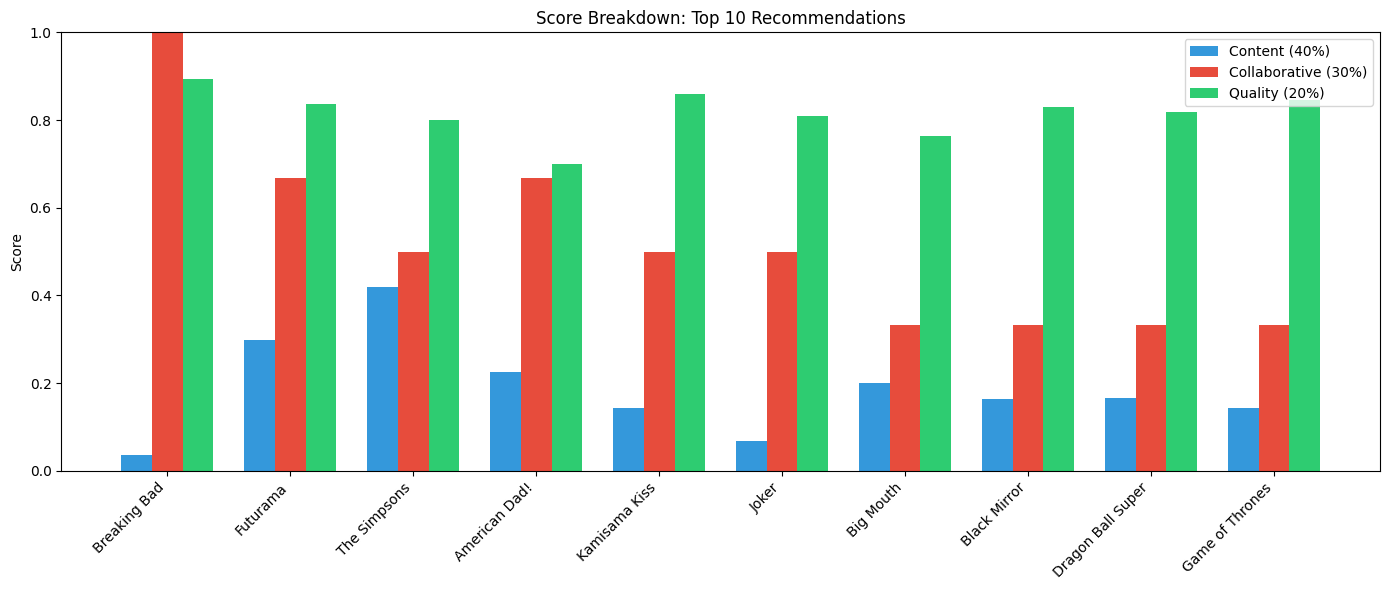

In [19]:
import matplotlib.pyplot as plt

# Plot score breakdown for top 10
top_10 = filtered_results[:10]
titles = [r["title"][:20] for r in top_10]
content = [r["content_score"] for r in top_10]
collab = [r["collab_score"] for r in top_10]
quality = [r["quality_score"] for r in top_10]
x = np.arange(len(titles))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(x - width, content, width, label='Content (40%)', color='#3498db')
ax.bar(x, collab, width, label='Collaborative (30%)', color='#e74c3c')
ax.bar(x + width, quality, width, label='Quality (20%)', color='#2ecc71')

ax.set_ylabel('Score')
ax.set_title('Score Breakdown: Top 10 Recommendations')
ax.set_xticks(x)
ax.set_xticklabels(titles, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

---
## 🎓 Summary: What You Learned

1. **TF-IDF** converts text (genres, keywords, overview) into numerical vectors
2. **Cosine Similarity** measures how "aligned" two vectors are (0 to 1)
3. **User Profile** = average of TF-IDF vectors for items you watched
4. **Hybrid Scoring** combines content + collaborative + quality signals
5. Recommendations are **personalized** to YOUR watch history, not generic top lists